# Use trained model as AI Annotator

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/elsevier/Bert-NER-V2'
%cd $path
import sqlite3
import random
import utils_train as ut
import net
from transformers import BertForMaskedLM, BertTokenizer
import torch
!pip install highlight-text
import matplotlib.pyplot as plt
from highlight_text import HighlightText
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/elsevier/Bert-NER-V2


## Load parameters

In [2]:
CLASSES = {'MATERIAL': 1, 'MLIP': 2, 'PROPERTY': 3,
           'VALUE': 4, 'APPLICATION': 5, 'O': 0}
SEED = 32
MAX_LENGTH = 512
ut.seed_everything(SEED)
modelBERT = BertForMaskedLM.from_pretrained('pranav-s/MaterialsBERT')
tokenizerBERT = BertTokenizer.from_pretrained('pranav-s/MaterialsBERT', model_max_length=MAX_LENGTH)
model = net.NERBERTModel(modelBERT.base_model, output_size=len(CLASSES)+1)
exp_name = '2024-07-22_b_1_s_3242_l_512_w_[0.3, 1.0, 1.0, 1.0, 0.5, 0.5]_l_0.0001'
epoch = 5
parameter_path = path + f'/saved_models/{exp_name}/{exp_name}_e_{epoch}.pt'
model.load_state_dict(torch.load(parameter_path))
model.eval()
print('Model loaded')

Model loaded


In [3]:
def inference(text, model, tokenizer, max_length):
    text_list = ut.split_para(text)
    token_list = tokenizer.convert_tokens_to_ids(text_list)
    data_test = torch.tensor(token_list + [0] * (max_length - len(token_list)))[None, :]
    att_mask_test = torch.tensor([1] * len(text_list) + [0] * (max_length - len(text_list)))[None, :]
    y_pred_test = model(data_test, attention_mask=att_mask_test)
    y_pred_test = torch.swapaxes(y_pred_test, 1, 2)
    pred = y_pred_test.max(dim=1)[1][0][:len(text_list)]
    return pred, text_list

def inference_batch(texts, model, tokenizer, max_length):
    results = []
    for text in texts:
        pred, text_list = inference(text, model, tokenizer, max_length)
        results.append((pred, text_list))
    return results

def show_pred(pred, text_list):
    colors = ['black', 'red', 'blue', 'green', 'cyan', 'darkorange']
    word_list_marked = ['<' + w + '>' for w in text_list]
    markers = [{"color": colors[i]} for i in pred]
    j = 0
    for i in range(len(text_list)):
        if (i + 1) % 20 == 0:
            word_list_marked.insert(i + j, '\n')
            j += 1
    fig, ax = plt.subplots()
    ax.set_axis_off()
    HighlightText(x=0., y=1, s='<O>, <MATERIAL>, <MLIP>, <PROPERTY>, <VALUE>, <APPLICATION>',
                  highlight_textprops=[{"color": c} for c in colors], ax=ax)
    HighlightText(x=0., y=0.9, s=' '.join(word_list_marked),
                  highlight_textprops=markers, ax=ax)
    plt.show()

In [4]:
# Batch of papers
e1 = "We demonstrate how the many-body potential energy landscape of carbon can be explored with the nested sampling algorithm, allowing for the calculation of its pressure-temperature phase diagram. We compare four interatomic potential models: Tersoff, EDIP, GAP-20 and its recently updated version, GAP-20U. Our evaluation is focused on their macroscopic properties, melting transitions, and identifying thermodynamically stable solid structures up to at least 100 GPa. The phase diagrams of the GAP models show good agreement with experimental results. However, we find that the models’ description of graphite includes thermodynamically stable phases with incorrect layer spacing. By adding a suitable selection of structures to the database and re-training the potential, we have derived an improved model — GAP-20U+gr — that suppresses erroneous local minima in the graphitic energy landscape. At extreme high pressure nested sampling identifies two novel stable structures in the GAP-20 model, however, the stability of these is not confirmed by electronic structure calculations, highlighting routes to further extend the applicability of the GAP models."
e2 = "Realistically modelling how solvents affect catalytic reactions is a longstanding challenge due to its prohibitive computational cost. Typically, an explicit atomistic treatment of the solvent molecules is needed together with molecular dynamics (MD) simulations and enhanced sampling methods. Here, we demonstrate the utility of machine learning interatomic potentials (MLIPs), coupled with active learning, to enable fast and accurate explicit solvent modelling of adsorption and reactions on heterogeneous catalysts. MLIPs trained on-the-fly were able to accelerate ab initio MD simulations by up to 4 orders of magnitude while reproducing with high fidelity the geometrical features of water in the bulk and at metal–water interfaces. Using these ML-accelerated simulations, we accurately predicted key catalytic quantities such as the adsorption energies of CO*, OH*, COH*, HCO*, and OCCHO* on Cu surfaces and the free energy barriers of C–H scission of ethylene glycol over Cu and Pd surfaces, as validated with ab initio calculations. We envision that such simulations will pave the way towards detailed and realistic studies of solvated catalysts at large time- and length-scales."
e3 = "The inherent discontinuity and unique dimensional attributes of nanomaterial surfaces and interfaces bestow them with various exceptional properties. These properties, however, also introduce difficulties for both experimental and computational studies. The advent of machine learning interatomic potential (MLIP) addresses some of the limitations associated with empirical force fields, presenting a valuable avenue for accurate simulations of these surfaces/interfaces of nanomaterials. Central to this approach is the idea of capturing the relationship between system configuration and potential energy, leveraging the proficiency of machine learning (ML) to precisely approximate high-dimensional functions. This review offers an in-depth examination of MLIP principles and their execution and elaborates on their applications in the realm of nanomaterial surface and interface systems. The prevailing challenges faced by this potent methodology are also discussed."
examples = [e1, e2, e3]
results = inference_batch(examples, model, tokenizerBERT, MAX_LENGTH)

# Show prediction

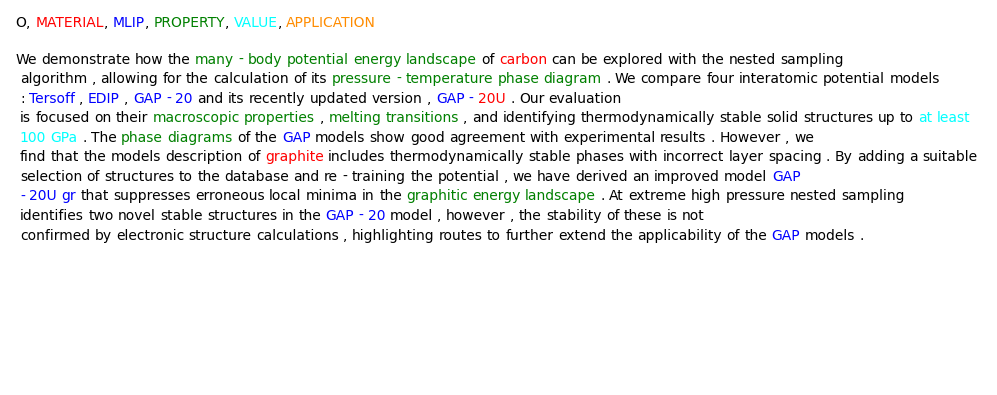

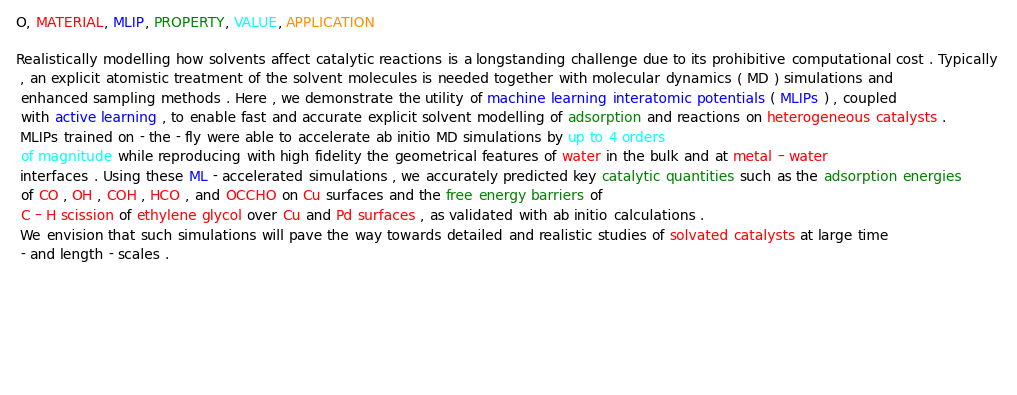

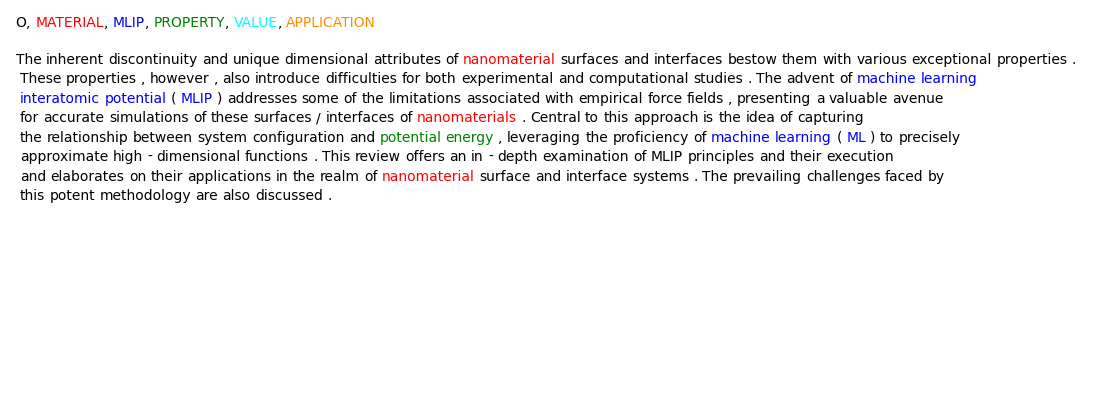

In [5]:
for result in results:
    show_pred(*result)

In [10]:
CLASSES = {1:'MATERIAL', 2:'MLIP', 3:'PROPERTY',
           4:'VALUE', 5:'APPLICATION', 0:'O'}

def result2data(pred, text_list, classes):
    body = " ".join(text_list)
    annotation = {}
    annotation_list = [(index, classes[i.item()]) for index, i in enumerate(pred) if i.item() > 0]
    for i in annotation_list:
        annotation[str(i[0])] = i[1]
    annotation = str(annotation)
    return body, annotation

def result2data_batch(results, classes):
    bodies = []
    annotations = []
    for result in results:
        body, annotation = result2data(*result, classes)
        bodies.append(body)
        annotations.append(annotation)
        data = [bodies, annotations]
    return list(zip(*data))
data_AI = result2data_batch(results, CLASSES)

In [12]:
#Put results in a database
DB_PATH = '/content/drive/MyDrive/elsevier/flask_dev/instance/AnnoApp.sqlite'

def insert_data(data, DB_PATH):
    con = sqlite3.connect(DB_PATH)
    cur = con.cursor()
    for d in data:
        cur.execute("INSERT INTO post (body, annotation) VALUES (?, ?)", d)
    con.commit()
    con.close()
insert_data(data_AI, DB_PATH)